In [1]:
from typing import List
import logging
from dataclasses import dataclass

import numpy as np
import pandas as pd
import seaborn as sns

import Bio
import Bio.PDB
import Bio.SVDSuperimposer

from utils import *

In [4]:
def get_dataset_summary():
    df = pd.read_csv("data/SAbDab-Fv-unbound/20210927_0887165_summary.tsv", sep='\t')
    df.drop_duplicates(subset = ["pdb"], keep = 'first', inplace = True)
    df.set_index("pdb", inplace = True)
    df = df[["Hchain", "Lchain", "engineered"]].copy()
    return df

df = get_dataset_summary()
print(f"""
    - Shape: {df.shape}
    - #engineered: {(df.engineered == True).sum()}
""")
df.head(3)


    - Shape: (398, 3)
    - #engineered: 361



,Hchain,Lchain,engineered
pdb,,,
6eyn,D,C,True
5bq7,A,B,True
1vge,H,L,True


In [5]:
ids = set(df.index)
NUM_SAMPLES = 10
samples = sample_pairs(ids, num_pairs = NUM_SAMPLES)
# print(samples)

records = []
for pair in samples:
    try:
        name1 = pair[0]
        name2 = pair[1]
        path1 = f"data/SAbDab-Fv-unbound/chothia/{name1}.pdb"
        path2 = f"data/SAbDab-Fv-unbound/chothia/{name2}.pdb"
        hchain_name_1 = df.loc[name1]['Hchain']
        lchain_name_1 = df.loc[name1]['Lchain']
        hchain_name_2 = df.loc[name2]['Hchain']
        lchain_name_2 = df.loc[name2]['Lchain']

        parser = Bio.PDB.PDBParser(PERMISSIVE=0)  # strict parser
        structure1 = parser.get_structure(name1, path1)
        structure2 = parser.get_structure(name2, path2)

        h_res_1, l_res_1 = extract_variable_regions_residues(structure1, hchain_name_1, lchain_name_1)
        h_res_2, l_res_2 = extract_variable_regions_residues(structure2, hchain_name_2, lchain_name_2)

        coord_h1 = extract_calpha_coord(h_res_1)
        coord_l1 = extract_calpha_coord(l_res_1)
        coord_h2 = extract_calpha_coord(h_res_2)
        coord_l2 = extract_calpha_coord(l_res_2)

        sup = Bio.SVDSuperimposer.SVDSuperimposer()
        rmsd_h12 = compute_rmsd(coord_h1, coord_h2, sup)
        rmsd_l12 = compute_rmsd(coord_l1, coord_l2, sup)
        rmsd_v12 = compute_rmsd(
            np.vstack([coord_h2, coord_l2]),
            np.vstack([coord_h1, coord_l1]),
        )

        record = {
            "pdb1": name1,
            "pdb2": name2,
            "rmsd_h12": rmsd_h12,
            "rmsd_l12": rmsd_l12,
            "engineered_1": df.loc[name1]['engineered'],
            "engineered_2": df.loc[name2]['engineered'],
        }
        records.append(record)
    except:
        pass

res = pd.DataFrame.from_records(records)
# print(res.shape)
res.to_csv(f"results_N{NUM_SAMPLES}.tsv")
res.head(3)

,pdb1,pdb2,rmsd_h12,rmsd_l12,engineered_1,engineered_2
0,4ocs,4xcc,6.880439,6.803280,True,True
1,5n4j,6med,11.101781,5.109151,True,True
2,4lkc,6apc,7.107955,7.673546,True,True


In [6]:
pair_eng_classes = []
for _, s in res.iterrows():
    eng_1 = bool(s['engineered_1'])
    eng_2 = bool(s['engineered_2'])
    
    if eng_1 and eng_2:
        label = "both"
    elif eng_1 or eng_2:
        label = "one"
    elif not (eng_1 or eng_2):
        label = "none"

    pair_eng_classes.append(label)

res['engineered_label'] = pair_eng_classes

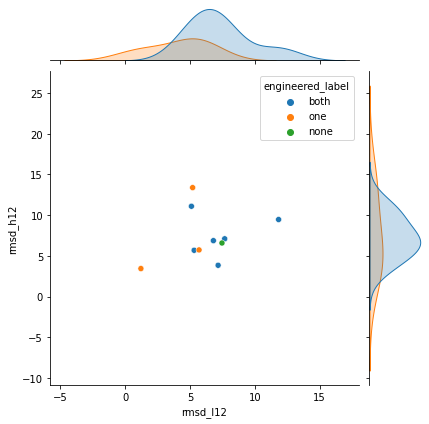

In [7]:
sns.jointplot(data=res, x='rmsd_l12', y='rmsd_h12', hue='engineered_label')
# res.plot.scatter(x='rmsd_l12', y='rmsd_h12')